In [1]:
!pip install --upgrade epss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import requests
import pandas as pd
import matplotlib.pyplot as plt   

Download CISA vulnerabilities

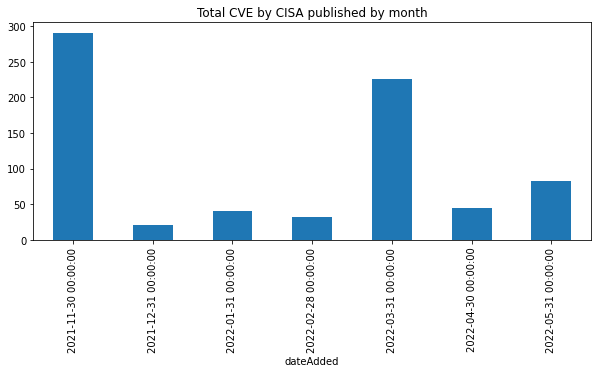

In [43]:
cisa_df = pd.read_csv('https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv',parse_dates=['dateAdded','dueDate'])


cisa_df.set_index("dateAdded").resample('M').size().plot.bar(figsize=(10,4),title='Total CVE by CISA published by month')
plt.show()

In [44]:
cisa_df.columns

Index(['cveID', 'vendorProject', 'product', 'vulnerabilityName', 'dateAdded',
       'shortDescription', 'requiredAction', 'dueDate', 'notes'],
      dtype='object')

In [45]:
cisa_df.dtypes

cveID                        object
vendorProject                object
product                      object
vulnerabilityName            object
dateAdded            datetime64[ns]
shortDescription             object
requiredAction               object
dueDate              datetime64[ns]
notes                       float64
dtype: object

# Take the vulns published by CISA yesterday

In [61]:
# Filter CVE from this month for example
month_df = cisa_df.loc[(cisa_df['dateAdded'] >= '2022-05-25')]
month_df.shape

(34, 9)

Now let's find the EPSS scores for those vulns

In [62]:
from epss import epss
import logging

logging.basicConfig(level=logging.INFO)
client = epss.EPSS()

In [64]:
found = []
for idx,row in month_df.iterrows():
  epss_df,status=client.get(cve=row['cveID'])
  if epss_df.shape[0]>0:
    found.append(epss_df)
epss_df = pd.concat(found)

In [78]:
enrich_df = pd.merge(month_df,epss_df,left_on=['cveID'],right_index=True)
enrich_df['epss']=enrich_df['epss'].astype(float)

In [79]:
enrich_df.head(5)

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,notes,epss,percentile,date
703,CVE-2019-3010,Oracle,Solaris,Oracle Solaris Privilege Escalation Vulnerability,2022-05-25,Oracle Solaris component: XScreenSaver contain...,Apply updates per vendor instructions.,2022-06-15,NaN,0.17164,0.959200000,2022-05-26
704,CVE-2016-3393,Microsoft,Windows,Microsoft Windows Graphics Device Interface (G...,2022-05-25,A remote code execution vulnerability exists d...,Apply updates per vendor instructions.,2022-06-15,NaN,0.32828,0.975110000,2022-05-26
705,CVE-2016-7256,Microsoft,Windows,Microsoft Windows Open Type Font Remote Code E...,2022-05-25,A remote code execution vulnerability exists w...,Apply updates per vendor instructions.,2022-06-15,NaN,0.31179,0.974380000,2022-05-26
706,CVE-2016-1010,Adobe,Flash Player and AIR,Adobe Flash Player and AIR Integer Overflow Vu...,2022-05-25,Integer overflow vulnerability in Adobe Flash ...,The impacted products are end-of-life and shou...,2022-06-15,NaN,0.03731,0.838300000,2022-05-26
707,CVE-2016-0984,Adobe,Flash Player and AIR,Adobe Flash Player and AIR Use-After-Free Vuln...,2022-05-25,Use-after-free vulnerability in Adobe Flash Pl...,The impacted products are end-of-life and shou...,2022-06-15,NaN,0.84976,0.996390000,2022-05-26


# Sort by EPSS

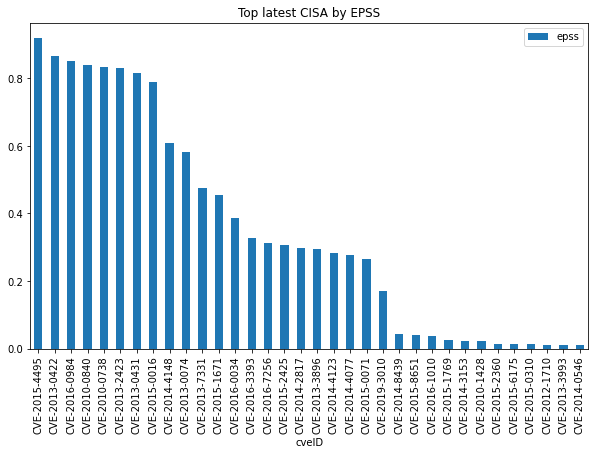

In [84]:
# sort by epss
enrich_df.sort_values(by='epss',ascending=False).plot.bar(x='cveID',y='epss',title='Top latest CISA by EPSS',figsize=(10,6))
plt.show()